# `maxvol` Experiments

## 1 Validation

### Comparison to maximum volume

To validate that our `maxvol` implementation is working correctly, we start by applying it to some small matrices and comparing the volume of the submatrices returned by `maxvol` to the volume of the actual maximum-volume submatrix.

We can only do this for small matrices, as the brute-force approach to finding a maximum-volume submatrix is too slow on larger matrices.

In [1]:
import maxvol
import numpy as np
import itertools

np.random.seed(1)

n = 15
r = 5

for i_test in range(10):
    print(f'Test {i_test + 1}')

    # Create an n x r, "tall" matrix
    a = np.random.random((n, r))

    # Use maxvol to find rows of a .01-dominant submatrix
    maxvol_rows = maxvol.maxvol(a)

    # Find volume of actual maximum-volume submatrix
    actual_max_vol = max(abs(np.linalg.det(a[list(rows)])) for rows in itertools.combinations(range(n), r))

    # Compare volume of the .01-dominant submatrix to the maximum volume
    print(f'Maximum volume: {actual_max_vol}. maxvol volume: {abs(np.linalg.det(a[maxvol_rows]))}')
    print()

Test 1
Maximum volume: 0.5366752450817541. maxvol volume: 0.5366752450817541

Test 2
Maximum volume: 0.5545454225031443. maxvol volume: 0.5545454225031443

Test 3
Maximum volume: 0.5234028767117629. maxvol volume: 0.5166856866649765

Test 4
Maximum volume: 0.27227040790671525. maxvol volume: 0.27227040790671525

Test 5
Maximum volume: 0.3938772359753359. maxvol volume: 0.3938772359753359

Test 6
Maximum volume: 0.7479532751986617. maxvol volume: 0.7479532751986617

Test 7
Maximum volume: 0.6201321996537785. maxvol volume: 0.6201321996537785

Test 8
Maximum volume: 0.5283941647586463. maxvol volume: 0.5277097845490392

Test 9
Maximum volume: 0.3487940501293589. maxvol volume: 0.3487940501293589

Test 10
Maximum volume: 0.6218098346651663. maxvol volume: 0.6218098346651663



From these results, we see that `maxvol` often finds a maximum-volume submatrix, and if it doesn't, the submatrix it finds still has a fairly large volume compared to the maximum.

### $\delta$-Dominance

Next, we verify for a somewhat larger input matrix that `maxvol` actually does return a $\delta$-dominant submatrix.

In [2]:
for i_test in range(5):
    # Create a larger "tall" matrix
    a = np.random.random((20000, 100))

    # Get maxvol submatrix rows
    maxvol_rows = maxvol.maxvol(a)

    # Check Chebyshev norm of AB^{-1}, where B is the submatrix from maxvol
    print(f'Test {i_test + 1}')
    print(f'Dominance check value: {np.abs(a @ np.linalg.inv(a[maxvol_rows])).max()} < 1 + 0.01')
    print()

Test 1
Dominance check value: 1.0032225389582785 < 1 + 0.01

Test 2
Dominance check value: 1.0000000000000013 < 1 + 0.01

Test 3
Dominance check value: 1.0023761163295808 < 1 + 0.01

Test 4
Dominance check value: 1.0072833005063093 < 1 + 0.01

Test 5
Dominance check value: 1.0091807044614634 < 1 + 0.01



## 2 Pseudo-skeleton Decomposition

The `maxvol.pseudo_skeleton` function is an implementation of the alternating row-column search algorithm for finding a maximum-volume submatrix of a non-tall matrix. We compare the pseudo-skeleton decomposition found using this method to the truncated SVD of the same rank for a Gaussian random field matrix.

First, we load the matrix.

In [3]:
# Load pre-generated matrix of size 1000 x 1000
x = np.load('x.npy')

Second, we compute the SVD of the matrix and plot the decay of the singular values to get an idea of how low the rank of the matrix is.

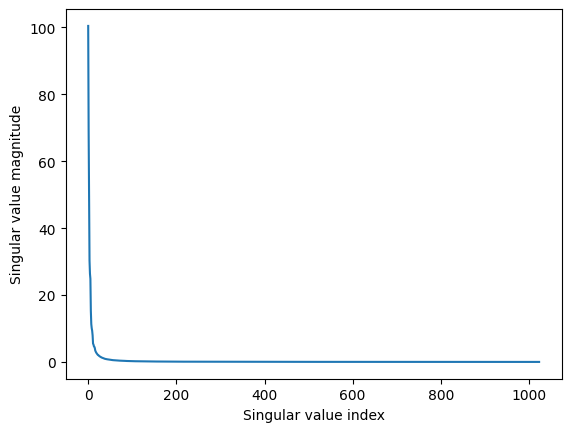

In [4]:
import matplotlib.pyplot as plt

# Get singular values
_, d, _ = np.linalg.svd(x)

# Plot singular values
plt.plot(d)
plt.xlabel('Singular value index')
plt.ylabel('Singular value magnitude')
plt.show()

The singular values decay very quickly, so a low-rank approximation should work well on this matrix. Let's start with the optimal rank-20 approximation, the truncated SVD. Note that `maxvol.truncated_svd` returns left and right matrix factors that can be multiplied to obtain the approximation of the original matrix. We report the Frobenius norm error of the approximation.

In [5]:
best_left, best_right = maxvol.truncated_svd(x, 20)
print(f'Frobenius error: {np.linalg.norm(x - best_left @ best_right)}')

Frobenius error: 8.03229808807373


Now we compute a pseudo-skeleton decomposition of the original matrix using `maxvol`. We report the Frobenius norm error of this approximation.

In [6]:
rows, cols, left, right = maxvol.pseudo_skeleton(x, 20, rtol=.5)
print(f'Frobenius error: {np.linalg.norm(x - left @ right)}')

Frobenius error: 17.778648376464844


We see that the pseudo-skeleton method achieves an error on the same order of magnitude as the best approximation obtained by SVD. However, the pseudo-skeleton algorithm is **much** faster, as we see below. This is in spite of the fact that the SVD implementation `np.linalg.svd` is highly optimized, whereas our `maxvol` implementation is written in Python/NumPy, and therefore nowhere near as optimized as it could be if implemented natively.

In [7]:
import timeit

print(f'SVD mean run time (s): '
      f'{timeit.timeit(lambda: maxvol.truncated_svd(x, 20), number=20) / 20}')
print(f'Pseudo-skeleton mean run time (s): '
      f'{timeit.timeit(lambda: maxvol.pseudo_skeleton(x, 20, rtol=.5), number=20) / 20}')


SVD mean run time (s): 0.5607704100009869
Pseudo-skeleton mean run time (s): 0.015355390000331681


Displaying the matrix and the reconstructions as images, we can see visually that both the truncated SVD and pseudo-skeleton approximations are qualitatively good.

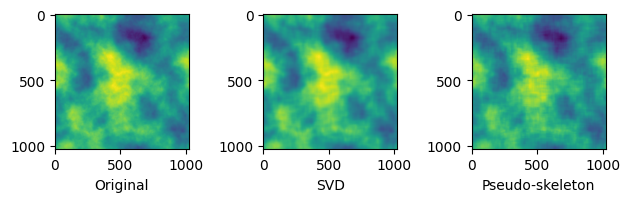

In [8]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(x)
ax1.set_xlabel('Original')
ax2.imshow(best_left @ best_right)
ax2.set_xlabel('SVD')
ax3.imshow(left @ right)
ax3.set_xlabel('Pseudo-skeleton')
plt.tight_layout()
plt.show()

## 3 Finding a maximal element

We take one last experiment from "How to Find a Good Submatrix", in which they use `maxvol` to find the element of maximum absolute value in a low-rank matrix by finding a dominant submatrix and returning the maximum value in that matrix.

First, we construct a $1000\times 1000$ matrix of rank 10 using the method of "How to Find a Good Submatrix".

In [9]:
big_left = np.linalg.qr(np.random.random((1000, 10)))[0] * np.random.uniform(.1, 1, 10)[None]
big_right = np.linalg.qr(np.random.random((10000, 10)))[0]
big_matrix = big_left @ big_right.T

Now we apply the pseudo-skeleton decomposition algorithm to find a good submatrix of the big one, and find the maximum element of the pseudo-skeleton decomposition and compare with the true maximal element.

In [10]:
row_indices, col_indices, left, right = maxvol.pseudo_skeleton(big_matrix, 25, rtol=.5)
print(f'True maximum {np.abs(big_matrix).max()}')
print(f'Approximate maximum {np.abs(big_matrix[row_indices, col_indices]).max()}')

True maximum 0.003434336924943314
Approximate maximum 0.001822295346216159


Now repeat this experiment a few times.

In [11]:
for i_test in range(5):
    big_left = np.linalg.qr(np.random.random((1000, 10)))[0] * np.random.uniform(.1, 1, 10)[None]
    big_right = np.linalg.qr(np.random.random((10000, 10)))[0]
    big_matrix = big_left @ big_right.T
    
    row_indices, col_indices, left, right = maxvol.pseudo_skeleton(big_matrix, 25, rtol=.01)
    
    print(f'Trial {i_test + 1}')
    print(f'True maximum {np.abs(big_matrix).max()}')
    print(f'True mean: {np.mean(np.abs(big_matrix))}, true std.: {np.std(np.abs(big_matrix))}')
    print(f'Approximate maximum {np.abs(big_matrix[row_indices, col_indices]).max()}')
    print()

Trial 1
True maximum 0.0033087505958642473
True mean: 0.0004507771483685019, true std.: 0.0003449587368936961
Approximate maximum 0.0017446386155358683

Trial 2
True maximum 0.003262140914732878
True mean: 0.00046835217327718584, true std.: 0.00035980146338205943
Approximate maximum 0.002200818820975112

Trial 3
True maximum 0.0035777377839508375
True mean: 0.0005136303437169384, true std.: 0.0003951833955805014
Approximate maximum 0.001665445288235828

Trial 4
True maximum 0.003419546530269774
True mean: 0.000454107526706503, true std.: 0.0003497895897712429
Approximate maximum 0.0022065959460137205

Trial 5
True maximum 0.00317514966353248
True mean: 0.00048033793738535787, true std.: 0.00036519426503817
Approximate maximum 0.0024003580105399704

